In [11]:
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt
import cv2, os, shutil

In [13]:
import os, shutil
home = os.getcwd()
backupPath = os.path.join(home, 'backup')

# 기존의 폴더가 있으면 삭제 후 다시 생성
orgDataPath =  os.path.join(home, 'org')
if os.path.exists(orgDataPath):
    shutil.rmtree(orgDataPath)
shutil.copytree(backupPath, orgDataPath)

'C:\\Users\\SBA\\transbox\\guarana\\org'

In [14]:
from glob import glob 

# 원본 데이터셋이 저장된 폴더
imagefiles = glob(os.path.join(orgDataPath, '*.JPG'))
labelfiles = glob(os.path.join(orgDataPath, '*.txt'))

In [15]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, width, height, color=BOX_COLOR, thickness=2):
    dataType = "yolo"
    """Visualizes a single bounding box on the image"""

    if dataType == 'coco':
        x_min, y_min, w, h = bbox

        x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    elif dataType =='yolo':
        x_center, y_center, w, h = bbox
        # 정규화된 값 0~1사이의 값
        # 픽셀 좌표로 변환 이미지의 width와 height값을 곱해주면 된다.
        x_min = int((x_center - (w/2)) * width)
        x_max = int((x_center + (w/2)) * width)
        y_min = int((y_center - (h/2)) * height)
        y_max = int((y_center + (h/2)) * height)
    print(x_min, x_max, y_min,y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, img_shape):
    img = image.copy()
    h, w = img_shape
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name, w, h)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
def read_label_txt(txtFile):
    category_ids = []
    bboxes = []

    f=open(txtFile,'r')

    while True:
        line = f.readline()
        if not line: break
        ids, xc, yc, w, h= line.split(' ')
        category_ids.append(int(ids))
        bboxes.append([float(xc),float(yc),float(w),float(h)])
        #print(line)
    f.close()
    return category_ids, bboxes

In [17]:
def write_label_txt(txtFile, category_ids, bboxes):
    f=open(txtFile,'w')

    for i, ids in enumerate(category_ids):
        xc,yc,w,h = bboxes[i]
        f.write("{} {} {} {} {}".format(int(ids),xc,yc,w,h))
        #print("{} {}".format(int(ids), bboxes[i]))
    f.close()

In [19]:
DEBUG = False

def dataAug(func, imagefiles):
    for imagefile in imagefiles:
        image = cv2.imread(imagefile)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width = image.shape[0:2]
    
        # txt파일은 이미지 파일에서 확장자만 다르다!
        baseName = imagefile.split('.')[0]
        txtFile = baseName+'.txt'
        category_ids, bboxes = read_label_txt(txtFile)
        
        if func=='hflip':
            transformed = transform_hflip(image=image, bboxes=bboxes, category_ids=category_ids)
            saveImageName = baseName + '_hflip.JPG'  
            saveLabelName = baseName + '_hflip.txt'
            saveImage = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
            cv2.imwrite(saveImageName, saveImage)
            write_label_txt(saveLabelName, transformed['category_ids'], transformed['bboxes'])            
        elif func=='rotate':
            angle_inter = 20
            for angle in range(angle_inter,360,angle_inter):
                transform_rotate = A.Compose(
                    [A.Rotate(limit=(angle,angle), rotate_method='ellipse', p=1.0)],
                    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids'])
                )
                transformed = transform_rotate(image=image, bboxes=bboxes, category_ids=category_ids)
                saveImageName = baseName + '_rotate_{}.JPG'.format(angle)  
                saveLabelName = baseName + '_rotate_{}.txt'.format(angle)  
                saveImage = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                cv2.imwrite(saveImageName, saveImage)
                write_label_txt(saveLabelName, transformed['category_ids'], transformed['bboxes'])
        elif func=='resize':
            transformed = transform_resize(image=image, bboxes=bboxes, category_ids=category_ids)
            saveImageName = baseName + '.JPG'  
            saveLabelName = baseName + '.txt'            
            saveImage = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
            cv2.imwrite(saveImageName, saveImage)
            write_label_txt(saveLabelName, transformed['category_ids'], transformed['bboxes'])
        elif func=='hsv':
            transformed = transform_hsv(image=image, bboxes=bboxes, category_ids=category_ids)
            saveImageName = baseName + '_hsv.JPG'  
            saveLabelName = baseName + '_hsv.txt'
            saveImage = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
            cv2.imwrite(saveImageName, saveImage)
            write_label_txt(saveLabelName, transformed['category_ids'], transformed['bboxes'])  
        elif func=='shift':
            transformed = transform_shift(image=image, bboxes=bboxes, category_ids=category_ids)
            saveImageName = baseName + '_shift.JPG'  
            saveLabelName = baseName + '_shift.txt'
            saveImage = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
            cv2.imwrite(saveImageName, saveImage)
            write_label_txt(saveLabelName, transformed['category_ids'], transformed['bboxes'])
        elif func=='scale':
            transformed = transform_scale(image=image, bboxes=bboxes, category_ids=category_ids)
            saveImageName = baseName + '_scale.JPG'  
            saveLabelName = baseName + '_scale.txt'
            saveImage = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
            cv2.imwrite(saveImageName, saveImage)
            write_label_txt(saveLabelName, transformed['category_ids'], transformed['bboxes'])             
            
        if DEBUG==True:
            visualize(
                transformed['image'],
                transformed['bboxes'],
                transformed['category_ids'],
                category_id_to_name,
                img_width, img_height
            )
            break

In [20]:
transform_resize = A.Compose(
    [A.LongestMaxSize(max_size=800, interpolation=cv2.INTER_LINEAR),],
    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

transform_hflip = A.Compose(
    [A.HorizontalFlip(p=1.0)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

transform_hsv = A.HueSaturationValue(
    hue_shift_limit=(-5,5),
    sat_shift_limit=(20,20),
    val_shift_limit=(30,30),
    p=0.7
)

transform_shift = A.Compose(
    [A.ShiftScaleRotate(shift_limit=(-0.2, 0.2), scale_limit=(0, 0), rotate_limit=(0, 0),p=1.0)],
    bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.2, label_fields=['category_ids']),
)

transform_scale = A.Compose(
    [A.ShiftScaleRotate(shift_limit=(0, 0), scale_limit=(-0.2, 0.2), rotate_limit=(0, 0),p=1.0)],
    bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.2, label_fields=['category_ids']),
)

In [21]:
dataAug('resize', imagefiles)
dataAug('hflip', imagefiles)
dataAug('rotate', imagefiles)

In [22]:
imagefiles2 = glob(os.path.join(orgDataPath, '*.JPG'))
dataAug('hsv', imagefiles2)

imagefiles3 = glob(os.path.join(orgDataPath, '*.JPG'))
dataAug('shift', imagefiles3)

imagefiles4 = glob(os.path.join(orgDataPath, '*.JPG'))
dataAug('scale', imagefiles4)

In [ ]:
category_id_to_name = {0: 'kido'}

In [ ]:
visualize(img, bboxes, category_ids, category_id_to_name, img_shape)

NameError: name 'bboxes' is not defined

In [77]:
'''
Rotate image and compute new bounding box
@param image - image to be rotated
@param angle - rotation angle
@param bounding_box - original bounding box
@return: the rotated image and the new bounding box
'''
def rotate_image( image, angle, bounding_box ):

    # get image dimension
    img_height, img_width = image.shape[:2]

    # get rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D( center = (img_width // 2, img_height // 2), angle = angle, scale = 1.0 )

    # apply transformation (ratate image)
    rotated_image = cv2.warpAffine( image, rotation_matrix, (img_width, img_height) )

    # --- compute new bounding box ---
    # Apply same transformation to the four bounding box corners
    print(f'bounding box 0: {bounding_box[0]} 1:{bounding_box[1]} 2:{bounding_box[2]} 3:{bounding_box[3]}')
    rotated_point_A = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[1], 1] ).T )
    rotated_point_B = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[1], 1] ).T )
    rotated_point_C = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[3], 1] ).T )
    rotated_point_D = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[3], 1] ).T )
    # Compute new bounding box, that is, the bounding box for rotated object
    x = np.array( [ rotated_point_A[0], rotated_point_B[0], rotated_point_C[0], rotated_point_D[0] ] )
    y = np.array( [ rotated_point_A[1], rotated_point_B[1], rotated_point_C[1], rotated_point_D[1] ] )
    new_boundingbox = [np.min( x ).astype(int), np.min( y ).astype(int), np.max( x ).astype(int), np.max( y ).astype(int)]
    print(f'new_boundingbox:{new_boundingbox}')

    return rotated_image, new_boundingbox

# def width_shift_image( image, width_shift_range, boundingbox ):

#     img_height, img_width = image.shape[:2]
#     factor = img_width * width_shift_range

#     M = np.float32([[1,0,factor],[0,1,0]])
#     shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )

#     # compute new bounding box
#     shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )
#     shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )

#     new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int),
#                         shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]

#     return shifted_image, new_boundingbox

# def height_shift_image( image, height_shift_range, boundingbox ):

#     img_height, img_width = image.shape[:2]
#     factor = height_shift_range * img_height

#     M = np.float32([[1,0,0],[0,1,factor]])
#     shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )

#     # compute new bounding box
#     shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )
#     shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )

#     new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int),
#                         shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]

#     return shifted_image, new_boundingbox

# def scale_image( image, scale_factor, boundingbox ):

#     img_height, img_width = original_image.shape[:2]

#     width = (int)(scale_factor * img_width)
#     height = (int)(scale_factor * img_height)

#     scaled_img = cv2.resize( image, (width,height) )

#     scaling_marix = np.array( [ [scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, scale_factor] ] )

#     scaled_point_A = np.matmul( scaling_marix, np.array( [boundingbox[0], boundingbox[1], 1] ).T )
#     scaled_point_C = np.matmul( scaling_marix, np.array( [boundingbox[2], boundingbox[3], 1] ).T )

#     new_boundingbox = [ scaled_point_A[0].astype(int), scaled_point_A[1].astype(int),
#                         scaled_point_C[0].astype(int), scaled_point_C[1].astype(int) ]

#     return scaled_img, new_boundingbox

In [78]:
t_dic = { "rotation":rotate_image, "width_shift":width_shift_image, "height_shift":height_shift_image, "scale": scale_image }
f_dic = { "rotation":(0, 90), "width_shift":(0, 0.5), "height_shift":(0, 0.5), "scale": (0.5, 1.5)}

'''
Apply the specidied transdormation n times
return: a list with all transformated images, it bounding box and the value factor used.
'''
def apply_transformation( image, bounding_box, transformation, n ):
    import random

    t_images_list = []

    for i in range(0, n):
        interval = f_dic[transformation]
        # print(f'interval:{interval}')
        factor = random.uniform(interval[0], interval[1])
        # print(f'factor:{factor}')
        img, bb = t_dic[transformation]( image, factor, bounding_box )
        # print(f'bounding_box:{bounding_box}')
        t_images_list.append( (img, bb, factor) )

    return t_images_list

In [79]:
original_image = 'k1_f_0.jpg'
original_image = cv2.imread(imgPath)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

txtFile = 'k1_f_0.txt'
_, original_boundingbox = read_label_txt(txtFile)
rotated_images = apply_transformation( original_image, original_boundingbox[0], "rotation", 16 )

bounding box 0: 0.495540976524353 1:0.49897301197052 2:0.6231880187988281 3:0.26693999767303467
new_boundingbox:[np.int64(-173), np.int64(239), np.int64(-172), np.int64(239)]
bounding box 0: 0.495540976524353 1:0.49897301197052 2:0.6231880187988281 3:0.26693999767303467
new_boundingbox:[np.int64(-199), np.int64(419), np.int64(-198), np.int64(419)]
bounding box 0: 0.495540976524353 1:0.49897301197052 2:0.6231880187988281 3:0.26693999767303467
new_boundingbox:[np.int64(-195), np.int64(464), np.int64(-195), np.int64(464)]
bounding box 0: 0.495540976524353 1:0.49897301197052 2:0.6231880187988281 3:0.26693999767303467
new_boundingbox:[np.int64(-142), np.int64(631), np.int64(-142), np.int64(631)]
bounding box 0: 0.495540976524353 1:0.49897301197052 2:0.6231880187988281 3:0.26693999767303467
new_boundingbox:[np.int64(-74), np.int64(69), np.int64(-74), np.int64(69)]
bounding box 0: 0.495540976524353 1:0.49897301197052 2:0.6231880187988281 3:0.26693999767303467
new_boundingbox:[np.int64(-196), 

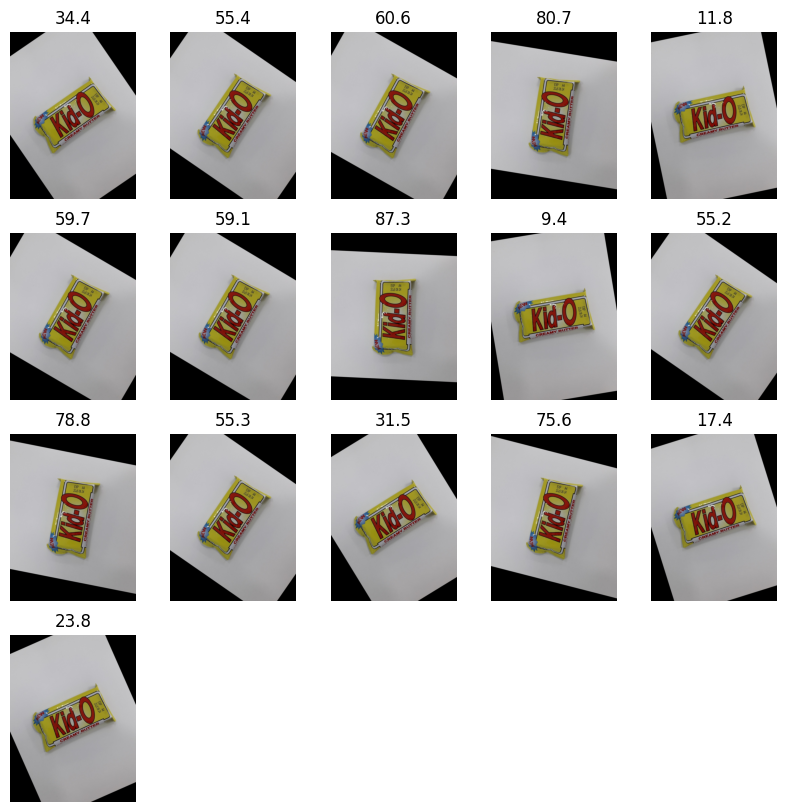

In [80]:
import utils as u
u.plot_images( rotated_images )